Кирилл Лалаянц, R33352

# Лабораторная работа No11
# В -- 11
## 𝐻2 и 𝐻∞

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy
import cvxpy 
import array_to_latex as a2l
# plt.rcParams['text.usetex'] = True

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)
np.set_printoptions(precision=2)
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

In [2]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")


In [18]:
A = np.array([
    [0, 1],
    [0, 0],
])
a2l.to_ltx(A)

B_2 = np.array([[0],
                [1]])
a2l.to_ltx(B_2)

\begin{bmatrix}
  0.00 &  1.00\\
  0.00 &  0.00
\end{bmatrix}
\begin{bmatrix}
  0.00\\
  1.00
\end{bmatrix}


## Task1

In [57]:
task1_B_1 = np.array([[1, 0],
                [0, 1]])
a2l.to_ltx(task1_B_1)

task1_C_2s = np.array([
    [[1, 1],
     [0, 1],
     [0, 0]],
    [[0, 0],
     [1, 0],
     [0, 0]],
])
task1_D_2s = np.array([[[0], [0], [1]], [[1], [0], [1]]])

ts = get_t(15)
w = np.vstack([0.05 * np.sin(ts), 0.01 * np.sin(10 * ts)])

\begin{bmatrix}
  1.00 &  0.00\\
  0.00 &  1.00
\end{bmatrix}


Eigen values of A:
   [0.]: controllable
   [0.]: controllable
Eigen values of A:
   [0.]: observable
   [0.]: observable
\[C_2 = \begin{bmatrix}
  1.00 &  1.00\\
  0.00 &  1.00\\
  0.00 &  0.00
\end{bmatrix}; D_2 = \begin{bmatrix}
  0.00\\
  0.00\\
  1.00
\end{bmatrix};\]
\[C_2^T D_2 = 0: True\]
\[D_2^T D_2 \text{ обратима}: True\]
\[spec(A-B_2 K) = \begin{bmatrix}
 -1.00 + 0.00j & -1.00 + -0.00j
\end{bmatrix}\]
\[Q = \begin{bmatrix}
  1.00 &  1.00\\
  1.00 &  2.00
\end{bmatrix}\]


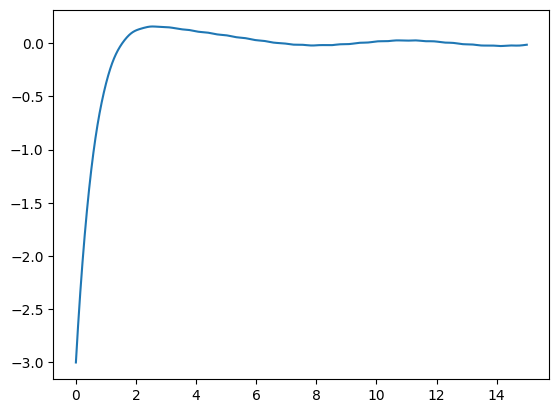

In [76]:
i = 0
task1_C_2 = task1_C_2s[i]
task1_D_2 = task1_D_2s[i]
check_controllability_eigens(A, B_2)
check_observability_eigens(task1_C_2, A)
Q = task1_C_2.T @ task1_C_2
R = task1_D_2.T @ task1_D_2
K, S, E = control.lqr(A, B_2, Q, R)
print(f'\[C_2 = {a2l.to_ltx(task1_C_2, print_out=False)}; D_2 = {a2l.to_ltx(task1_D_2, print_out=False)};\]')
print(f'\[C_2^T D_2 = 0: {np.all(task1_C_2.T @ task1_D_2 == 0)}\]')
print(f'\[D_2^T D_2 \\text{"{ обратима}"}: {np.linalg.det(task1_D_2.T @ task1_D_2) != 0}\]')
print(f'\[spec(A-B_2 K) = {a2l.to_ltx(E, print_out=False)}\]')
print(f'\[Q = {a2l.to_ltx(S, print_out=False)}\]')
ss = control.ss(A - B_2@K, task1_B_1, task1_C_2 - task1_D_2 @ K, np.zeros((task1_C_2.shape[0], task1_B_1.shape[1])))

resp = control.forced_response(ss, X0=np.ones((2, 1)), T=ts, U=w)
resp_z = resp.outputs
plt.plot(ts, resp_z[2])
